In [53]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest

In [54]:
metrics=[]

## Only Text

In [55]:
pres = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
pres =pres[pres["id"]=="covid_memes_155"]
text = pres["processed_text_alt"]
print(text)

259    house fauci unveils mask could save million life
Name: processed_text_alt, dtype: object


In [56]:
import warnings
warnings.filterwarnings('ignore')

# Load your datasets
train = pd.read_csv("data_train_preprocessed.csv", keep_default_na=False)
val = pd.read_csv("data_val_preprocessed.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data_test_preprocessed.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["processed_text_alt"])
X_val = vectorizer.transform(val["processed_text_alt"])
X_test = vectorizer.transform(test["processed_text_alt"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Define the grid of parameters to search through
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
rf_text = RandomForestClassifier(**grid_search.best_params_, random_state=42, class_weight="balanced")
rf_text.fit(X_train, y_train)

# Make predictions on the test set
pred_test = rf_text.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test)}")
print(f"Recall on test set: {recall_score(y_test, pred_test)}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test)}")

text_metrics={
    "Model": "Random Forest",
    "Data": "Text",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(text_metrics)


# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score from validation set: 0.6532539682539683
Accuracy on test set: 0.7429378531073446
Precision on test set: 0.6064516129032258
Recall on test set: 0.7580645161290323
F1-Score on test set: 0.6738351254480287
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       230
           1       0.61      0.76      0.67       124

    accuracy                           0.74       354
   macro avg       0.73      0.75      0.73       354
weighted avg       0.76      0.74      0.75       354



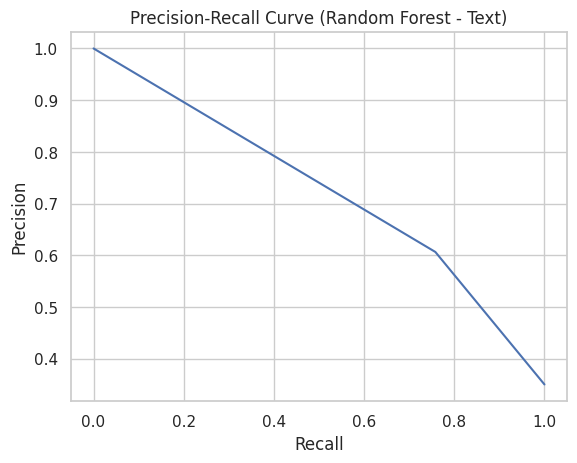

In [57]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Random Forest - Text)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-Random-Forest-Text.png")

## Lime

In [58]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, rf_text)

# Load test data
test = pd.read_csv("data_test_preprocessed.csv", keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["processed_text_alt"])

# Collecting explanations
df_pred = []
for idx, text in enumerate(test["processed_text_alt"]):
    exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": probs[idx, 1],
        "True Class": class_names[test["binary_labels"].iloc[idx]],
        "Explainers": exp.as_list(label=1)
    }
    df_pred.append(dict_pred)

df_pred = pd.DataFrame(df_pred)

for i in np.arange(0.0, 1.1, 0.1):
    i= round(i,1)
    var_name = f'PredClass_{i}'
    df_pred[var_name] = np.where(df_pred["Prob (Harmful)"] >= i, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_text = explainer_list.merge(df_pred, on="id")
explainer_df_text


,id,word,value,Prob (Harmful),True Class,Explainers,PredClass_0.0,PredClass_0.1,PredClass_0.2,PredClass_0.3,PredClass_0.4,PredClass_0.5,PredClass_0.6,PredClass_0.7,PredClass_0.8,PredClass_0.9,PredClass_1.0
0,0,trump,0.044626,0.512740,Not Harmful,"[(trump, 0.04462611881381298), (2020, -0.03630...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1,0,2020,-0.036302,0.512740,Not Harmful,"[(trump, 0.04462611881381298), (2020, -0.03630...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
2,0,twitter,0.007884,0.512740,Not Harmful,"[(trump, 0.04462611881381298), (2020, -0.03630...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
3,0,vaccine,0.003630,0.512740,Not Harmful,"[(trump, 0.04462611881381298), (2020, -0.03630...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
4,0,tomorrow,-0.000644,0.512740,Not Harmful,"[(trump, 0.04462611881381298), (2020, -0.03630...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,353,home,-0.023917,0.447867,Not Harmful,"[(home, -0.023917355173809204), (quarantine, -...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1633,353,quarantine,-0.020045,0.447867,Not Harmful,"[(home, -0.023917355173809204), (quarantine, -...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1634,353,vaccine,0.010206,0.447867,Not Harmful,"[(home, -0.023917355173809204), (quarantine, -...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1635,353,like,-0.007714,0.447867,Not Harmful,"[(home, -0.023917355173809204), (quarantine, -...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful


# Objects

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Load your datasets
train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
val = pd.read_csv("data/val_text_and_objects.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["objects"])
X_val = vectorizer.transform(val["objects"])
X_test = vectorizer.transform(test["objects"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Define the grid of parameters to search through
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
rf_objects = RandomForestClassifier(**grid_search.best_params_, random_state=42, class_weight="balanced")
rf_objects.fit(X_train, y_train)

# Make predictions on the test set
pred_test = rf_objects.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test)}")
print(f"Recall on test set: {recall_score(y_test, pred_test)}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test)}")

objects_metrics={
    "Model": "Random Forest",
    "Data": "Objects",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(objects_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score from validation set: 0.6058201058201057
Accuracy on test set: 0.596045197740113
Precision on test set: 0.4512820512820513
Recall on test set: 0.7096774193548387
F1-Score on test set: 0.5517241379310345
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.77      0.53      0.63       230
           1       0.45      0.71      0.55       124

    accuracy                           0.60       354
   macro avg       0.61      0.62      0.59       354
weighted avg       0.66      0.60      0.60       354



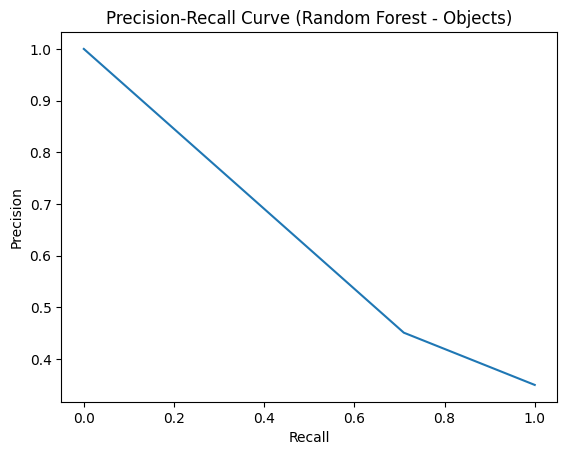

In [8]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Random Forest - Objects)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-Random-Forest-Objects.png")

## Lime

In [9]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, rf_objects)

# Load test data
test = pd.read_csv('data/test_text_and_objects.csv', keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["objects"])

In [10]:
df_pred = []
for idx, text in enumerate(test["objects"]):
    # Ensure the text is valid and non-empty
    if text and len(text.split()) > 0:
        exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
        #print('Document id: %d' % idx)
        dict_pred = {
            "id": idx,
            "Prob (Harmful)": probs[idx, 1],
            "True Class": class_names[test["binary_labels"].iloc[idx]],
            "Explainers": exp.as_list(label=1)
        }
        df_pred.append(dict_pred)
    else:
        print(f'Skipping document id: {idx} due to insufficient text')

Skipping document id: 0 due to insufficient text
Skipping document id: 33 due to insufficient text
Skipping document id: 55 due to insufficient text
Skipping document id: 56 due to insufficient text
Skipping document id: 83 due to insufficient text
Skipping document id: 92 due to insufficient text
Skipping document id: 97 due to insufficient text
Skipping document id: 101 due to insufficient text
Skipping document id: 106 due to insufficient text
Skipping document id: 115 due to insufficient text
Skipping document id: 117 due to insufficient text
Skipping document id: 119 due to insufficient text
Skipping document id: 134 due to insufficient text
Skipping document id: 160 due to insufficient text
Skipping document id: 165 due to insufficient text
Skipping document id: 172 due to insufficient text
Skipping document id: 176 due to insufficient text
Skipping document id: 198 due to insufficient text
Skipping document id: 220 due to insufficient text
Skipping document id: 225 due to insuff

In [11]:

df_pred = pd.DataFrame(df_pred)

for i in np.arange(0.0, 1.1, 0.1):
    i= round(i,1)
    var_name = f'PredClass_{i}'
    df_pred[var_name] = np.where(df_pred["Prob (Harmful)"] >= i, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_objects = explainer_list.merge(df_pred, on="id")
explainer_df_objects


,id,word,value,Prob (Harmful),True Class,Explainers,PredClass_0.0,PredClass_0.1,PredClass_0.2,PredClass_0.3,PredClass_0.4,PredClass_0.5,PredClass_0.6,PredClass_0.7,PredClass_0.8,PredClass_0.9,PredClass_1.0
0,1,tie,0.106915,0.351359,Not Harmful,"[(person, 0.08960765348385888), (sports, -0.06...",Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1,1,person,0.028442,0.351359,Not Harmful,"[(person, 0.08960765348385888), (sports, -0.06...",Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
2,2,tie,0.106980,0.709623,Not Harmful,"[(tie, 0.10691480333964813), (person, 0.028442...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful
3,2,person,0.028508,0.709623,Not Harmful,"[(tie, 0.10691480333964813), (person, 0.028442...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful
4,3,tie,0.082323,0.709623,Not Harmful,"[(tie, 0.10698047168665592), (person, 0.028508...",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,318,person,0.037297,0.524443,Not Harmful,"[(person, 0.03729700974755722)]",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
600,320,person,0.089560,0.524443,Not Harmful,"[(person, 0.03729700974755722)]",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
601,320,bed,-0.026255,0.524443,Not Harmful,"[(person, 0.03729700974755722)]",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
602,320,bottle,0.025190,0.524443,Not Harmful,"[(person, 0.03729700974755722)]",Harmful,Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful


## Text and Objects

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Load your datasets
train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
val = pd.read_csv("data/val_text_and_objects.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["text_and_objects"])
X_val = vectorizer.transform(val["text_and_objects"])
X_test = vectorizer.transform(test["text_and_objects"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Define the grid of parameters to search through
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
rf_text_objects = RandomForestClassifier(**grid_search.best_params_, random_state=42, class_weight="balanced")
rf_text_objects.fit(X_train, y_train)

# Make predictions on the test set
pred_test = rf_text_objects.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test)}")
print(f"Recall on test set: {recall_score(y_test, pred_test)}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test)}")

text_objects_metrics={
    "Model": "Random Forest",
    "Data": "Text and Objects",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(text_objects_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best score from validation set: 0.7548622687941574
Accuracy on test set: 0.7655367231638418
Precision on test set: 0.6257668711656442
Recall on test set: 0.8225806451612904
F1-Score on test set: 0.710801393728223
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       230
           1       0.63      0.82      0.71       124

    accuracy                           0.77       354
   macro avg       0.76      0.78      0.76       354
weighted avg       0.79      0.77      0.77       354



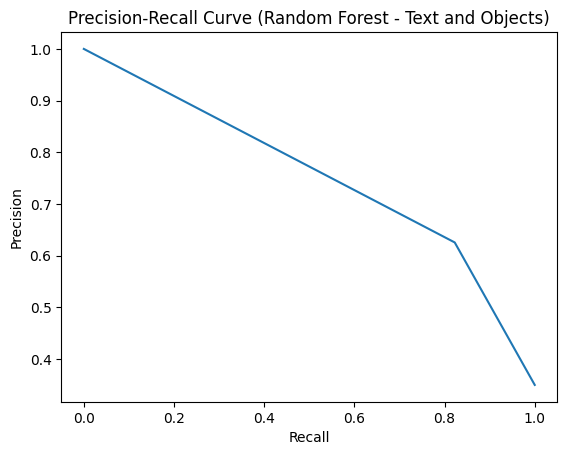

In [13]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Random Forest - Text and Objects)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-Random-Forest-Text-Objects.png")

## Lime

In [14]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, rf_text_objects)

# Load test data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["text_and_objects"])

# Collecting explanations
df_pred = []
for idx, text in enumerate(test["text_and_objects"]):
    exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": probs[idx, 1],
        "True Class": class_names[test["binary_labels"].iloc[idx]],
        "Explainers": exp.as_list(label=1)
    }
    df_pred.append(dict_pred)

df_pred = pd.DataFrame(df_pred)


for i in np.arange(0.0, 1.1, 0.1):
    i= round(i,1)
    var_name = f'PredClass_{i}'
    df_pred[var_name] = np.where(df_pred["Prob (Harmful)"] >= i, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_text_objects = explainer_list.merge(df_pred, on="id")
explainer_df_text_objects


,id,word,value,Prob (Harmful),True Class,Explainers,PredClass_0.0,PredClass_0.1,PredClass_0.2,PredClass_0.3,PredClass_0.4,PredClass_0.5,PredClass_0.6,PredClass_0.7,PredClass_0.8,PredClass_0.9,PredClass_1.0
0,0,2020,-0.032499,0.475527,Not Harmful,"[(2020, -0.032499008946138434), (trump, 0.0247...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1,0,trump,0.024713,0.475527,Not Harmful,"[(2020, -0.032499008946138434), (trump, 0.0247...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
2,0,vaccine,0.023130,0.475527,Not Harmful,"[(2020, -0.032499008946138434), (trump, 0.0247...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
3,0,oct,-0.012956,0.475527,Not Harmful,"[(2020, -0.032499008946138434), (trump, 0.0247...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
4,0,experimental,-0.006043,0.475527,Not Harmful,"[(2020, -0.032499008946138434), (trump, 0.0247...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,353,home,-0.030994,0.442140,Not Harmful,"[(home, -0.03099402797774855), (vaccine, 0.028...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1722,353,vaccine,0.028737,0.442140,Not Harmful,"[(home, -0.03099402797774855), (vaccine, 0.028...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1723,353,quarantine,-0.021683,0.442140,Not Harmful,"[(home, -0.03099402797774855), (vaccine, 0.028...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful
1724,353,person,0.014430,0.442140,Not Harmful,"[(home, -0.03099402797774855), (vaccine, 0.028...",Harmful,Harmful,Harmful,Harmful,Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful,Not Harmful


# Vizualisation

## Metric overview

In [15]:
metrics

[{'Model': 'Random Forest',
  'Data': 'Text',
  'Accuracy': 0.7429378531073446,
  'Precision': 0.6064516129032258,
  'Recall': 0.7580645161290323,
  'F1-Score': 0.6738351254480287},
 {'Model': 'Random Forest',
  'Data': 'Objects',
  'Accuracy': 0.596045197740113,
  'Precision': 0.4512820512820513,
  'Recall': 0.7096774193548387,
  'F1-Score': 0.5517241379310345},
 {'Model': 'Random Forest',
  'Data': 'Text and Objects',
  'Accuracy': 0.7655367231638418,
  'Precision': 0.6257668711656442,
  'Recall': 0.8225806451612904,
  'F1-Score': 0.710801393728223}]

In [16]:
metrics = pd.DataFrame(metrics)
metrics_values = metrics[["Data","Accuracy","Precision","Recall","F1-Score"]]

df_melted = metrics_values.melt('Data', var_name='Metrics', value_name='Values')
df_melted

,Data,Metrics,Values
0,Text,Accuracy,0.742938
1,Objects,Accuracy,0.596045
2,Text and Objects,Accuracy,0.765537
3,Text,Precision,0.606452
4,Objects,Precision,0.451282
5,Text and Objects,Precision,0.625767
6,Text,Recall,0.758065
7,Objects,Recall,0.709677
8,Text and Objects,Recall,0.822581
9,Text,F1-Score,0.673835


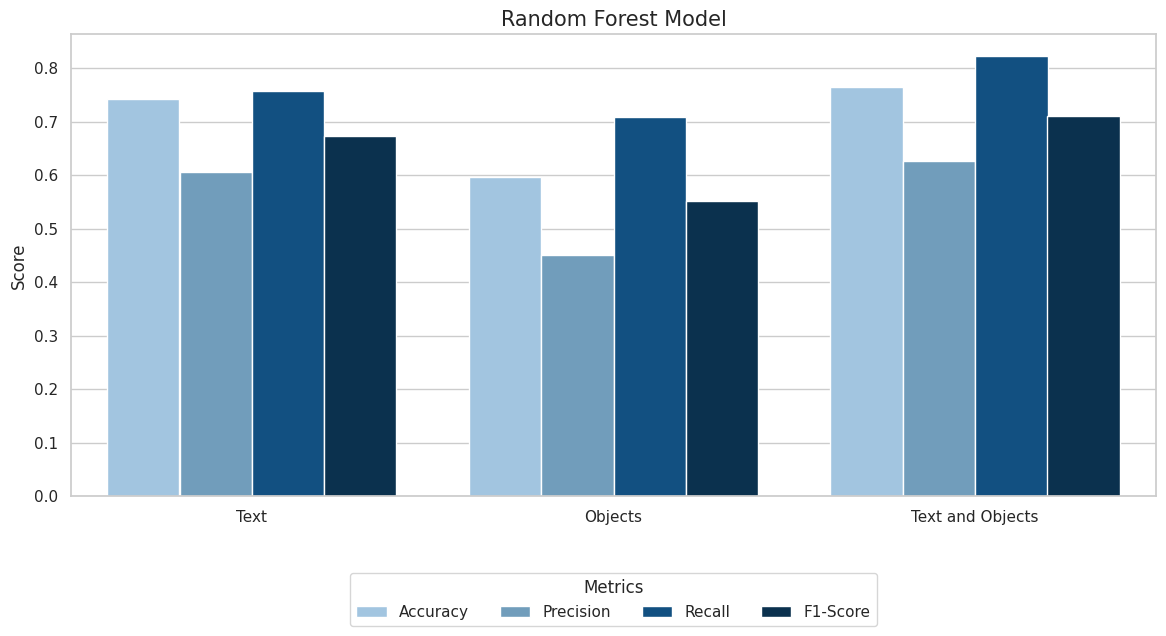

In [17]:
# Function to plot the data
def plot_metrics(df, color_dict):
    sns.set(style="whitegrid")
    # Melting the dataframe to have proper format for seaborn
    df_melted = df.melt('Data', var_name='Metrics', value_name='Values')
    plt.figure(figsize=(14, 6))
    # Creating the barplot
    barplot = sns.barplot(x='Data', y='Values', hue='Metrics', data=df_melted, palette=color_dict)
    # Customizing the plot
    barplot.set_title('Random Forest Model', fontsize=15)
    barplot.set_xlabel('', fontsize=12)
    barplot.set_ylabel('Score', fontsize=12)
    barplot.legend(title='Metrics', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)    # Display the plot
    plt.savefig("plots/Luca/Metrics-RandomForest.png",bbox_inches='tight')

custom_colors = {
    'Accuracy': '#98C6EA',  # Replace '#1f77b4' with your desired hex color code for Accuracy
    'Precision': '#64A0C8',  # Replace '#ff7f0e' with your desired hex color code for Precision
    'Recall': '#005293',    # Replace '#2ca02c' with your desired hex color code for Recall
    'F1-Score': '#003359'   # Replace '#d62728' with your desired hex color code for F1-Score
}

plot_metrics(metrics_values, custom_colors)


### Harmful Prediction

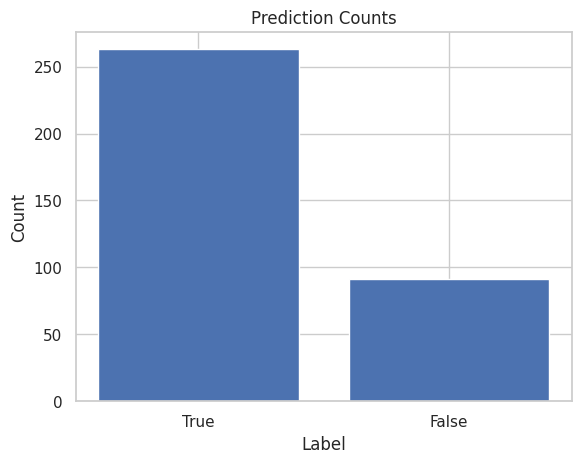

In [22]:
explainer_df_text["Prediction"] = np.where(explainer_df_text["PredClass_0.5"] == explainer_df_text["True Class"], True, False)
prediction = explainer_df_text[["id", "Prediction"]].drop_duplicates().reset_index(drop=True).value_counts("Prediction")

# Convert the Series to DataFrame and reset index to make "Prediction" a column
prediction_df = prediction.reset_index(name='count')
prediction_df.columns = ['label', 'count']

# Plotting
plt.bar(prediction_df['label'].astype(str), prediction_df['count'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Prediction Counts')
plt.show()


# LIME

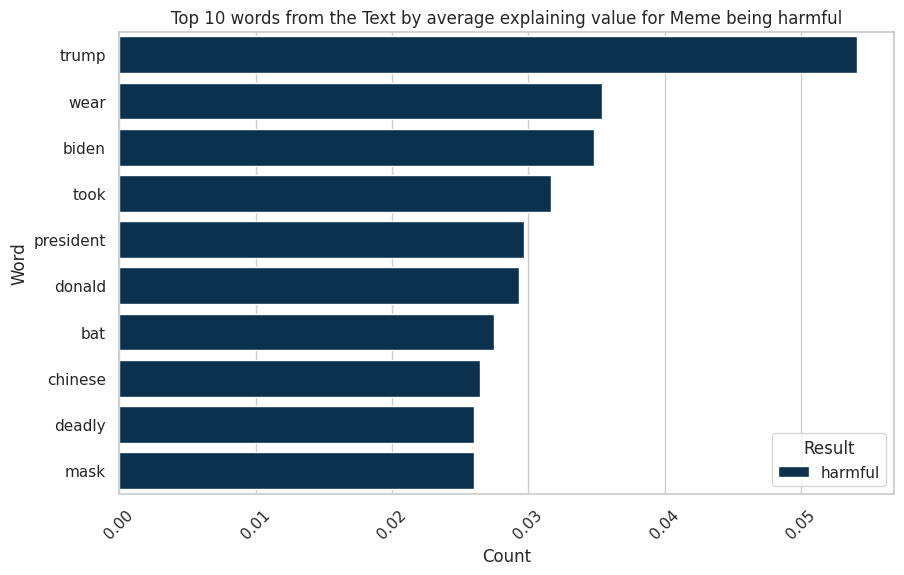

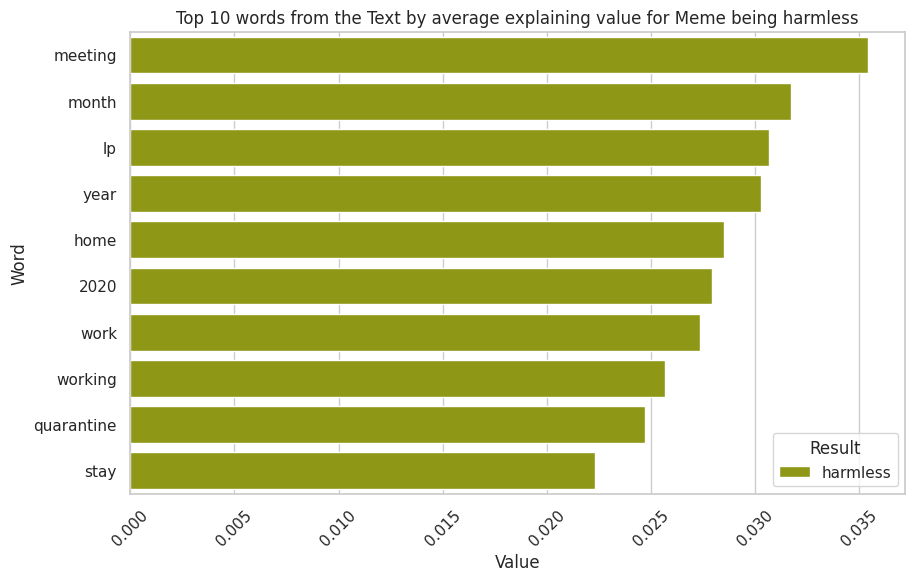

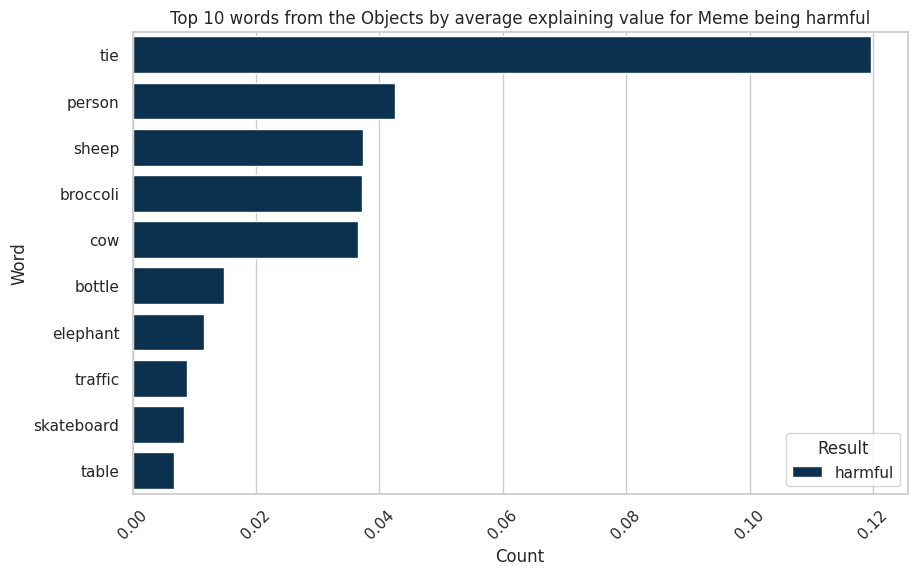

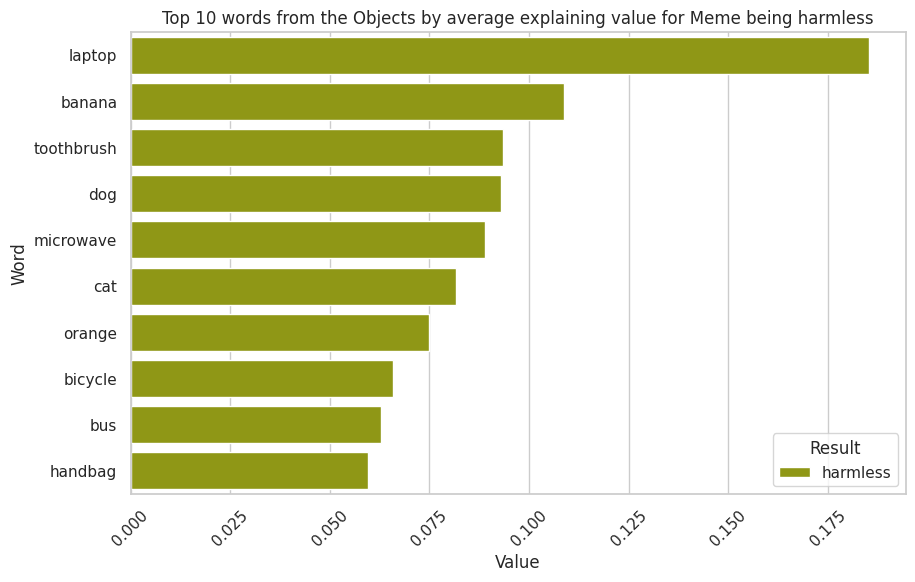

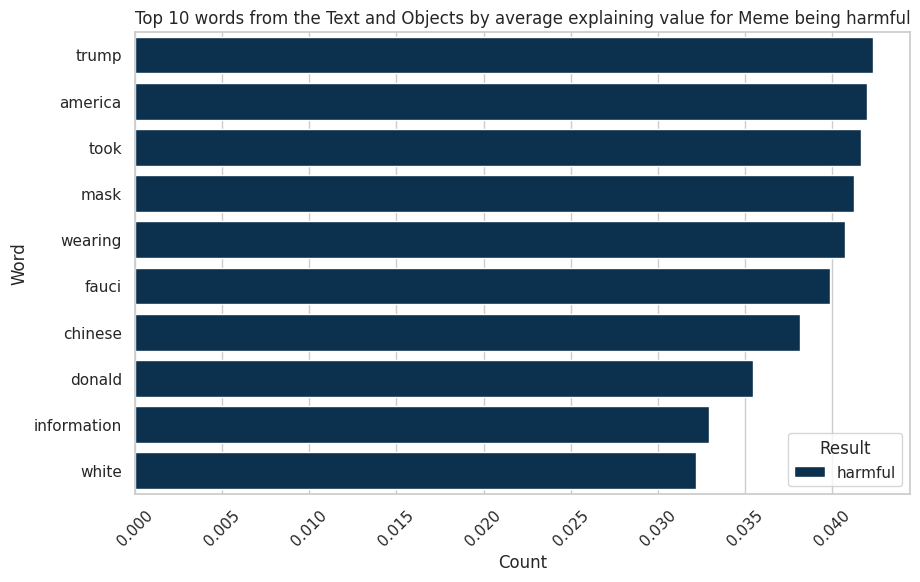

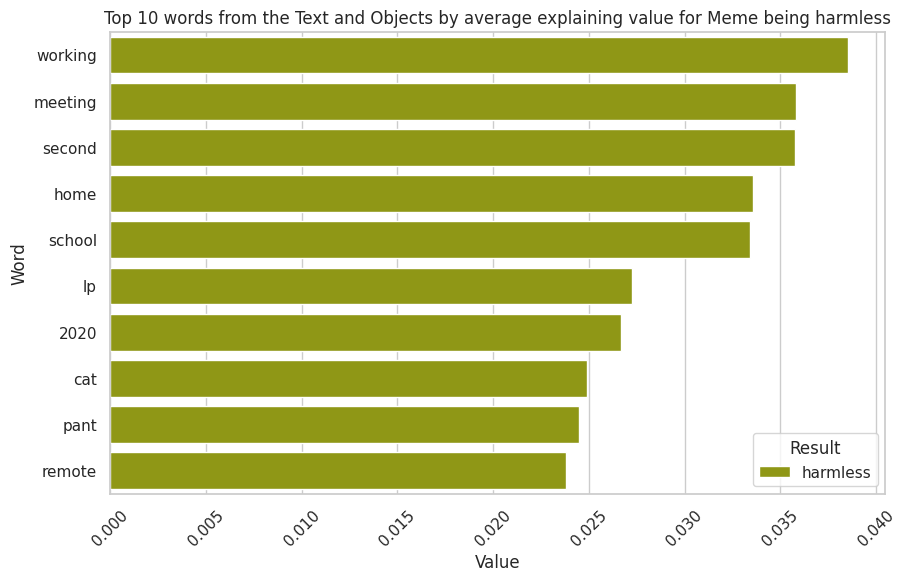

In [100]:
data = [explainer_df_text,explainer_df_objects,explainer_df_text_objects]
txt = ["Text","Objects","Text and Objects"]
file=["Text","Objects","Text_Objects"]


for i in range(0,3):
    df = data[i]
    type = txt[i]
    file_spec=file[i]
    model = "RandomForest"

    df=df[["word","value"]].groupby("word").mean("value")
    df["direction"] = np.where(df["value"]>0,"harmful","harmless")

    exp_p = df[df["direction"]=="harmful"].sort_values("value",ascending=False).head(10)
    exp_n = df[df["direction"]=="harmless"].sort_values("value",ascending=True).head(10)
    exp_n["value"]=exp_n["value"]*-1

    plt.figure(figsize=(10, 6))
    sns.barplot(y=exp_p.index, x='value',hue="direction" , data=exp_p, palette=["#003359"])

    # Adding legend and labels
    plt.legend(title='Result')
    plt.ylabel('Word')
    plt.xlabel('Count')
    plt.title(f'Top 10 words from the {type} by average explaining value for Meme being harmful')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

    # Display the plot
    plt.savefig(f"plots/Luca/Lime/{model}-Lime-{file_spec}-Positive.jpeg")

    plt.figure(figsize=(10, 6))
    sns.barplot(y=exp_n.index, x='value',hue="direction" , data=exp_n, palette=["#A2AD00"])

    # Adding legend and labels
    plt.legend(title='Result')
    plt.ylabel('Word')
    plt.xlabel('Value')
    plt.title(f'Top 10 words from the {type} by average explaining value for Meme being harmless')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

    # Display the plot
    plt.savefig(f"plots/Luca/Lime/{model}-Lime-{file_spec}-Negative.jpeg")
